In [54]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input,Bidirectional,LSTM,Dense,Dropout,Concatenate
import tensorflow_probability as tfp
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers

x_path = "data/"
y_path = "RECOLA/ratings_individual/ratings_individual/arousal/"
label_delay = 4
frame_length = 10
frame_step = 2
dropout_rate = 0.1
rcoeff = 0.001

from numpy.random import seed
import matplotlib.pyplot as plt
seed(1)

In [55]:
#split data into frames for training
def framer(x,y, frame_length, frame_step):
    num_steps,num_features = x.shape
    num_annotators = y.shape[-1]
    x_out = []
    y_out = []
    step = 0
    while (step+frame_length <= num_steps):
        frame_x = x[step:step+frame_length,:]
        frame_y = y[step:step+frame_length,:]
        x_out.append(frame_x)
        y_out.append(frame_y)
        step = step+frame_step
    
    x_out = np.array(x_out)
    y_out = np.array(y_out)
    
    return x_out, y_out

#read data from csv files and align
def read_data(file_name, x_path, y_path):
    #read input data
    x_file = x_path + file_name
    df = pd.read_csv(x_file,sep=";")
    x = df.drop(['name','frameTime'],axis=1).to_numpy()

    #read output data
    y_file = y_path + file_name
    df = pd.read_csv(y_file,sep=";")
    y = df.drop("time",axis=1).to_numpy()

    #shift labels and match lengths
    trunc_front = np.int_(label_delay/0.04)
    trunc_back = trunc_front + x.shape[0]
    y = y[trunc_front:trunc_back,:]

    return x,y

def scale_train_inputs(x):
    #scale input features to range 0-1
    #https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/
    x_flat = x.reshape(-1, x.shape[-1])
    xmin = np.amin(x_flat, axis=0)
    xmax = np.amax(x_flat, axis=0)
    scaled = (x-xmin)/(xmax-xmin)
    return scaled, xmin, xmax

def scale_test_inputs(x, xmin, xmax):
    scaled = (x-xmin)/(xmax-xmin)
    return scaled

def scale_train_labels(y):
    y_flat = y.reshape(-1, y.shape[-1])
    ymean = np.mean(y_flat, axis=0)
    ystd = np.std(y_flat, axis=0)
    scaled = (y-ymean)/(4*ystd)
#     print(y.shape)
    return scaled, ymean, ystd

def scale_test_labels(y, ymean, ystd):
    scaled = (y-ymean)/(4*ystd)
    return scaled

def ccc(x, y):
#     ccc = 0
    x = tf.reshape(x, tf.shape(x)[0:-1])
    y = tf.reshape(y, tf.shape(y)[0:-1])
#     print(x.shape)
    x_mean = tf.math.reduce_mean(x,axis=-1)
    y_mean = tf.math.reduce_mean(y,axis=-1)
#     print(x_mean.shape)
    x_var = tf.math.reduce_variance(x,axis=-1)
    y_var = tf.math.reduce_variance(y,axis=-1)
#     print(x_var.shape)
    
    cov = tfp.stats.covariance(x, y, sample_axis=-1, event_axis=0)
#     print(cov.shape)
    cov = tf.linalg.diag_part(cov)
#     print(cov.shape)
    ccc = (2*cov)/(x_var+y_var+tf.square((x_mean-y_mean)))
    ccc = tf.math.reduce_mean(ccc)
#     print(ccc)
    return ccc

def my_ccc(x, y):
    x = x.flatten()
    y = y.flatten()
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    x_var = np.var(x)
    y_var = np.var(y)
    
    cov = np.cov(x,y)[0,1]
    ccc = (2*cov)/(x_var+y_var+(x_mean-y_mean)**2)
    
#     print(cov, x_mean, y_mean, x_var, y_var)
    return ccc

#normalize features to normal distribution
def normalize_train_inputs(x):
    
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    
    features = (x-mean)/std
    
    return features, mean, std

#rescale labels to normal distribution/3
def normalize_labels(y):
    
    mean = np.mean(y, axis=0)
    std = np.std(y, axis=0)
    
    y = (y-mean)/(3*std)
    y = np.clip(y,a_min=-1,a_max=1)
    
    return y

def my_nll(y_true, y_pred, y_pred_std):
    
    mean = y_pred
    variance = np.square(y_pred_std)
    nll = []
    for i in range(6):
        nll.append((np.log(variance) / 2 + ((y_true[:,frame_length-1,i] - mean) ** 2) / (2 * variance)))
        
    nll = np.mean(np.array(nll))
    return nll

In [56]:
#extract data
x_train = []
y_train = []
x_test = []
y_test = []

#training data
for i in range(1,10):
    file_name = "train_" + str(i) + ".csv"
    print(file_name)
    x,y = read_data(file_name,x_path,y_path)
#     y = normalize_labels(y)
    x,y = framer(x,y,frame_length,frame_step)
    x_train.append(x)
    y_train.append(y)

x_train = np.vstack(x_train)
y_train = np.vstack(y_train)
#scale input features to range 0-1
x_train, xmin, xmax = scale_train_inputs(x_train)
# y_train, ymean, ystd = scale_train_labels(y_train)
# y_train, ymin, ymax = scale_train_inputs(y_train)

#test(devel) data
for i in range(1,10):
    file_name = "dev_" + str(i) + ".csv"
    print(file_name)
    x,y = read_data(file_name,x_path,y_path)
#     y = normalize_labels(y)
    x,y = framer(x,y,frame_length,frame_step)
    x_test.append(x)
    y_test.append(y)

x_test = np.vstack(x_test)
y_test = np.vstack(y_test)
#scale input features to range 0-1 from learned scaling
x_test = scale_test_inputs(x_test, xmin, xmax)
# y_test = scale_test_labels(y_test, ymean, ystd)
# y_test = scale_test_inputs(y_test, ymin, ymax)

#obtain individual ratings for ambiguity modelling
y_train_multi = [y_train[:,:,i].reshape(*y_train.shape[0:-1],1) for i in range(6)]
y_test_multi = [y_test[:,:,i].reshape(*y_train.shape[0:-1],1) for i in range(6)]
y_train_multi = np.concatenate(y_train_multi, axis=2)
y_test_multi = np.concatenate(y_test_multi, axis=2)

#obtain stdev for ambiguity modelling
y_train_std = np.std(y_train,axis=-1).reshape(*y_train.shape[0:-1],1)
y_test_std = np.std(y_test,axis=-1).reshape(*y_test.shape[0:-1],1)

y_train_var = np.var(y_train,axis=-1).reshape(*y_train.shape[0:-1],1)
y_test_var = np.var(y_test,axis=-1).reshape(*y_test.shape[0:-1],1)

#obtain mean for gold standard training (average of all raters)
y_train = np.mean(y_train,axis=-1).reshape(*y_train.shape[0:-1],1)
y_test = np.mean(y_test,axis=-1).reshape(*y_test.shape[0:-1],1)

#concat mean and stdev for normal distribution approximation
# y_train_normal = np.concatenate([y_train, y_train_std], axis=2)
# y_test_normal = np.concatenate([y_test, y_test_std], axis=2)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_test_multi.shape)
# print(y_test_multi.shape)

# import matplotlib.pyplot as plt

train_1.csv
train_2.csv
train_3.csv
train_4.csv
train_5.csv
train_6.csv
train_7.csv
train_8.csv
train_9.csv
dev_1.csv
dev_2.csv
dev_3.csv
dev_4.csv
dev_5.csv
dev_6.csv
dev_7.csv
dev_8.csv
dev_9.csv
(33264, 10, 88)
(33264, 10, 1)
(33264, 10, 88)
(33264, 10, 1)
(33264, 10, 6)


In [45]:
#build nll mean+std model
def my_nll_loss(y_true, y_pred):
    
#     y_true = y_true[:,:,0]
    mean = y_pred[:,:,0]
    variance = y_pred[:,:,1]
    mean2 = y_pred[:,:,2]
    variance2 = y_pred[:,:,3]
    
    nll = 0
#     alpha = 0.5
#     beta = 5
#     gamma = 7
    
    y = tf.math.reduce_mean(y_true,axis=2)
    var = tf.math.reduce_variance(y_true,axis=2)
    
    nll += 0.5*(tf.math.log(variance) + ((y - mean) ** 2)/variance + 1.837877)
    nll += 0.5*(tf.math.log(variance2) + ((var - mean2) ** 2)/variance2 + 1.837877)

    return nll
    
# tf.compat.v1.set_random_seed(42)
inputs = Input(shape=(frame_length,88))
x = Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=dropout_rate, kernel_regularizer=regularizers.l2(rcoeff)))(inputs, training=True)
x = Dropout(dropout_rate)(x, training=True)
x = Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=dropout_rate, kernel_regularizer=regularizers.l2(rcoeff)))(x, training=True)
x = Dropout(dropout_rate)(x, training=True)
# outputs = []
mean = Dense(1, activation="tanh")(x)
var = Dense(1, activation="softplus")(x)
mean_var = Dense(1, activation="softplus")(x)
var_var = Dense(1, activation="softplus")(x)
outputs = Concatenate()([mean, var, mean_var, var_var])
# outputs = Dense(2)(x) #means

model_nll = keras.Model(inputs, outputs)
model_nll.summary()

#train model
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_nll.compile(optimizer=optimizer, loss=my_nll_loss)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto', min_delta=0.0001, restore_best_weights=True)
model_nll.fit(x_train,y_train_multi, batch_size=100, epochs=100, validation_data=(x_test,y_test_multi), shuffle=True, callbacks=[early_stopping])


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 10, 88)]     0                                            
__________________________________________________________________________________________________
bidirectional_12 (Bidirectional (None, 10, 128)      78336       input_7[0][0]                    
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, 10, 128)      0           bidirectional_12[0][0]           
__________________________________________________________________________________________________
bidirectional_13 (Bidirectional (None, 10, 128)      98816       dropout_12[0][0]                 
____________________________________________________________________________________________

In [8]:
#build NIG 4 param model
def my_NIG_loss(y_true, y_pred):
    #train the model on NLL loss, given the 6 annotations
    #4 parameters of NIG prior
    alpha = y_pred[:,:,0]
    beta = y_pred[:,:,1]
    gamma = y_pred[:,:,2]
    nu = y_pred[:,:,3]
    
    omega = 2*beta*(1+nu)
#     y_true = y_true[:,:]
    #regularization coefficient
    rcoeff = 0.001
    
    #calculate nll loss as used in Amini et al.'s DER
    nll = 6 * (0.5*tf.math.log(3.14159/nu) - tf.math.multiply(alpha,tf.math.log(omega))+tf.math.lgamma(alpha)-tf.math.lgamma(alpha+0.5))
    
    #component of nll dependent on labels:
    for n in range(6):
        y = y_true[:,:,n]
        nll += tf.math.multiply((alpha+0.5),tf.math.log(tf.math.multiply(tf.math.square(y-gamma),nu)+omega))
        #regulariser
#         nll += rcoeff*tf.math.multiply(tf.math.abs(y-gamma),(2*nu+alpha))

    return nll
    
    
inputs = Input(shape=(frame_length,88))
x = Bidirectional(LSTM(32, return_sequences=True, recurrent_dropout=dropout_rate, kernel_regularizer=regularizers.l2(rcoeff)))(inputs, training=True)
x = Dropout(dropout_rate)(x, training=True)
x = Bidirectional(LSTM(32, return_sequences=True, recurrent_dropout=dropout_rate, kernel_regularizer=regularizers.l2(rcoeff)))(x, training=True)
x = Dropout(dropout_rate)(x, training=True)
alpha = Dense(1, activation="softplus")(x)
beta = Dense(1, activation="softplus")(x)
gamma = Dense(1, activation="tanh")(x)
nu = Dense(1, activation="softplus")(x)
outputs = Concatenate()([alpha+1, beta, gamma, nu]) #4 parameters of NIG distribution


model_NIG = keras.Model(inputs, outputs)
model_NIG.summary()

#train model
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_NIG.compile(optimizer=optimizer, loss=my_NIG_loss)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto', min_delta=0.0001, restore_best_weights=True)
model_NIG.fit(x_train,y_train_multi, batch_size=100, epochs=100, validation_data=(x_test,y_test_multi), shuffle=True, callbacks=[early_stopping])


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10, 88)]     0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 10, 64)       30976       input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 10, 64)       0           bidirectional_2[0][0]            
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 10, 64)       24832       dropout_2[0][0]                  
____________________________________________________________________________________________

In [46]:
def mcdropout_predict(x, model):
    num_learners = 50
    outputs = []
    for i in range(num_learners):
#         if (i % 10 == 0):
        print(i)
        pred = model.predict(x)
        outputs.append(pred)
    return np.array(outputs)
        
test_pred_nll = mcdropout_predict(x_test, model_nll)
# test_pred_NIG = mcdropout_predict(x_test, model_NIG)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


(33264, 2, 2)
0.7367202467557973
0.44530869338986806
-0.8168423590157664
0.12681142463784092
0.03543757764497688
0.06340212901726329


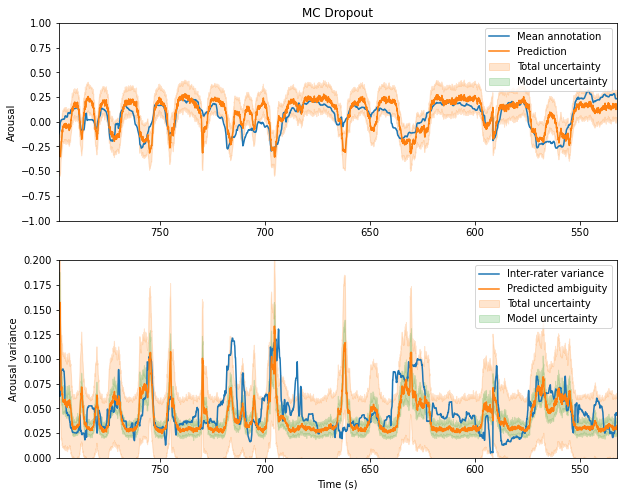

In [71]:
time_step = 0.04*frame_step
num_steps = test_pred_nll.shape[1]
file_num = 3
time_start = file_num*time_step*num_steps/10
time_end = (file_num-1)*time_step*num_steps/10
time_stamps = np.arange(num_steps)*time_step


test = y_test[:,frame_length-1,0].flatten()
test_pred = np.mean(test_pred_nll[:,:,frame_length-1,0],axis=0).flatten()
# test_std = y_test_std[:,frame_length-1,0].flatten()
test_std = np.var(y_test_multi[:,frame_length-1,:],axis=1).flatten()
test_pred_std = np.zeros((test.shape[0],))

num_models = 50
mv_pred = np.zeros([num_models,test_pred_nll.shape[1],1,2])
dunc = np.zeros([test_pred_nll.shape[1],2,2])
for m in range(num_models):
#     test_pred_std += test_pred_nll[m,:,frame_length-1,1] + np.square(test_pred_nll[m,:,frame_length-1,0])
    
    amb_m = test_pred_nll[m,:,frame_length-1,2]
    var_mu_m = test_pred_nll[m,:,frame_length-1,1]
    var_amb_m = test_pred_nll[m,:,frame_length-1,3]
    general_var_m = var_mu_m*var_amb_m

    mv_pred[m,:,0,0] = mu
    mv_pred[m,:,0,1] = amb_m
#   Using multivariate covariance
    dunc[:,0,0] += var_mu_m/num_models
    dunc[:,1,1] += var_amb_m/num_models

munc = np.zeros([test_pred_nll.shape[1],2,2])
mv_pred_ave = np.mean(mv_pred,axis=0)
print(munc.shape)
for m in range(num_models):
    diff_m = mv_pred[m,:,:] - mv_pred_ave
    munc += np.matmul( diff_m.transpose(0,2,1),diff_m)
#     print(diff_i[0,:,:])
#     print(diff_i.transpose(0,2,1)[0,:,:])
#     print(munc[0,:,:])
    
munc = munc/(num_models-1)

test_pred_std = mv_pred_ave[:,0,1]

munc_la = np.sqrt(munc[:,0,0])
dunc_la = np.sqrt(dunc[:,0,0])
tunc_la = np.sqrt(munc[:,0,0]+dunc[:,0,0])
munc_amb = np.sqrt(munc[:,1,1])
dunc_amb = np.sqrt(dunc[:,1,1])
tunc_amb = np.sqrt(munc[:,1,1]+dunc[:,1,1])
# dunc_1 = np.sqrt(np.linalg.det(dunc))
# munc_1 = np.sqrt(np.linalg.det(munc))

fig, axs = plt.subplots(2)
fig.set_size_inches(10,8)

axs[0].set_title('MC Dropout')
axs[0].set_xlim([time_start,time_end])
# axs[0].set_xlim([0,66519])
axs[0].set_ylim([-1,1])
# axs[0].set_xlabel('Frame')
axs[0].set_ylabel('Arousal')
axs[0].plot(time_stamps, test, label='Mean annotation')
axs[0].plot(time_stamps, test_pred, label='Prediction')
# for i in range(num_models):
#     axs[0].plot(np.abs(mv_pred[i,:,0,0]-mv_pred_ave[:,0,0])+0.5)
#     axs[0].plot(np.abs(mv_pred[i,:,0,1]-mv_pred_ave[:,0,1])-0.5)
# axs[0].plot(test_pred_unc)
# axs[0].plot(np.sqrt(munc_mean)-1, label='predicted model uncertainty - 1')
# axs[0].plot(np.sqrt()-1, label='predicted data uncertainty - 1')
axs[0].fill_between(time_stamps, test_pred-tunc_la,test_pred+tunc_la,color='C1',alpha=0.2, label='Total uncertainty')
axs[0].fill_between(time_stamps, test_pred-munc_la,test_pred+munc_la,color='C2',alpha=0.2, label='Model uncertainty')
axs[0].legend(loc='upper right')

axs[1].set_xlim([time_start,time_end])
# axs[1].set_xlim([0,66519])
axs[1].set_ylim([0,0.2])
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Arousal variance')
axs[1].plot(time_stamps, test_std, label='Inter-rater variance')
axs[1].plot(time_stamps, test_pred_std, label='Predicted ambiguity')
axs[1].fill_between(time_stamps, test_pred_std-tunc_amb,test_pred_std+tunc_amb,color='C1',alpha=0.2, label='Total uncertainty')
axs[1].fill_between(time_stamps, test_pred_std-munc_amb,test_pred_std+munc_amb,color='C2',alpha=0.2, label='Model uncertainty')
axs[1].legend(loc='upper right')

print(my_ccc(test,test_pred))
print(my_ccc(np.sqrt(test_std),np.sqrt(test_pred_std)))
print(my_nll(y_test_multi, test_pred, np.sqrt(test_pred_std+dunc[:,0,0]+munc[:,0,0])))
print(np.sqrt(np.mean((test-test_pred)**2)))
print(np.sqrt(np.mean((test_std-test_pred_std)**2)))
print(np.sqrt(np.mean((np.sqrt(test_std)-np.sqrt(test_pred_std))**2)))

(33264, 2, 2)
0.7499004897606284
0.4001461263975721
-0.7891922249185359


C:\Users\Hazmeme\AppData\Local\Temp/ipykernel_10452/2764911896.py:55: RuntimeWarning: invalid value encountered in sqrt
  dunc_amb = np.sqrt(dunc[:,1,1])
C:\Users\Hazmeme\AppData\Local\Temp/ipykernel_10452/2764911896.py:56: RuntimeWarning: invalid value encountered in sqrt
  tunc_amb = np.sqrt(munc[:,1,1]+dunc[:,1,1])


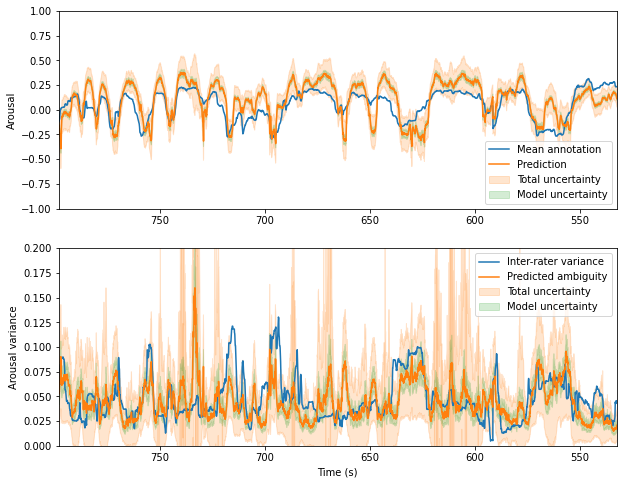

In [173]:
time_step = 0.04*frame_step
num_steps = test_pred_NIG.shape[1]
file_num = 3
time_start = file_num*time_step*num_steps/10
time_end = (file_num-1)*time_step*num_steps/10
time_stamps = np.arange(num_steps)*time_step


test = y_test[:,frame_length-1,0].flatten()
test_pred = np.mean(test_pred_NIG[:,:,frame_length-1,2],axis=0).flatten()
# test_std = y_test_std[:,frame_length-1,0].flatten()
test_std = np.var(y_test_multi[:,frame_length-1,:],axis=1).flatten()
test_pred_std = np.zeros((test.shape[0],))

num_models = 50
mv_pred = np.zeros([num_models,test_pred_NIG.shape[1],1,2])
dunc = np.zeros([test_pred_NIG.shape[1],2,2])
for m in range(num_models):
#     test_pred_std += test_pred_nll[m,:,frame_length-1,1] + np.square(test_pred_nll[m,:,frame_length-1,0])

    alpha = test_pred_NIG[m,:,frame_length-1,0].flatten()
    beta = test_pred_NIG[m,:,frame_length-1,1].flatten()
    mu = test_pred_NIG[m,:,frame_length-1,2].flatten()
    nu = test_pred_NIG[m,:,frame_length-1,3].flatten()
    
    amb_m = beta/(alpha-1)
    var_mu_m = amb_m/nu
    var_amb_m = np.power(beta,2)/(np.power(alpha-1,2)*(alpha-2))
    general_var_m = var_mu_m*var_amb_m

    mv_pred[m,:,0,0] = mu
    mv_pred[m,:,0,1] = amb_m
#   Using multivariate covariance
    dunc[:,0,0] += var_mu_m/num_models
    dunc[:,1,1] += var_amb_m/num_models

munc = np.zeros([test_pred_NIG.shape[1],2,2])
mv_pred_ave = np.mean(mv_pred,axis=0)
print(munc.shape)
for m in range(num_models):
    diff_m = mv_pred[m,:,:] - mv_pred_ave
    munc += np.matmul( diff_m.transpose(0,2,1),diff_m)
#     print(diff_i[0,:,:])
#     print(diff_i.transpose(0,2,1)[0,:,:])
#     print(munc[0,:,:])
    
munc = munc/(num_models-1)

test_pred_std = mv_pred_ave[:,0,1]

munc_la = np.sqrt(munc[:,0,0])
dunc_la = np.sqrt(dunc[:,0,0])
tunc_la = np.sqrt(munc[:,0,0]+dunc[:,0,0])
munc_amb = np.sqrt(munc[:,1,1])
dunc_amb = np.sqrt(dunc[:,1,1])
tunc_amb = np.sqrt(munc[:,1,1]+dunc[:,1,1])
# dunc_1 = np.sqrt(np.linalg.det(dunc))
# munc_1 = np.sqrt(np.linalg.det(munc))

fig, axs = plt.subplots(2)
fig.set_size_inches(10,8)

axs[0].set_xlim([time_start,time_end])
# axs[0].set_xlim([0,66519])
axs[0].set_ylim([-1,1])
# axs[0].set_xlabel('Frame')
axs[0].set_ylabel('Arousal')
axs[0].plot(time_stamps, test, label='Mean annotation')
axs[0].plot(time_stamps, test_pred, label='Prediction')
# for i in range(num_models):
#     axs[0].plot(np.abs(mv_pred[i,:,0,0]-mv_pred_ave[:,0,0])+0.5)
#     axs[0].plot(np.abs(mv_pred[i,:,0,1]-mv_pred_ave[:,0,1])-0.5)
# axs[0].plot(test_pred_unc)
# axs[0].plot(np.sqrt(munc_mean)-1, label='predicted model uncertainty - 1')
# axs[0].plot(np.sqrt()-1, label='predicted data uncertainty - 1')
axs[0].fill_between(time_stamps, test_pred-tunc_la,test_pred+tunc_la,color='C1',alpha=0.2, label='Total uncertainty')
axs[0].fill_between(time_stamps, test_pred-munc_la,test_pred+munc_la,color='C2',alpha=0.2, label='Model uncertainty')
axs[0].legend()

axs[1].set_xlim([time_start,time_end])
# axs[1].set_xlim([0,66519])
axs[1].set_ylim([0,0.2])
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Arousal variance')
axs[1].plot(time_stamps, test_std, label='Inter-rater variance')
axs[1].plot(time_stamps, test_pred_std, label='Predicted ambiguity')
axs[1].fill_between(time_stamps, test_pred_std-tunc_amb,test_pred_std+tunc_amb,color='C1',alpha=0.2, label='Total uncertainty')
axs[1].fill_between(time_stamps, test_pred_std-munc_amb,test_pred_std+munc_amb,color='C2',alpha=0.2, label='Model uncertainty')
axs[1].legend()

print(my_ccc(test,test_pred))
print(my_ccc(test_std,test_pred_std))
print(my_nll(y_test_multi, test_pred, np.sqrt(test_pred_std+dunc[:,0,0]+munc[:,0,0])))

In [136]:
#build nll mean+std model
def my_dual_nll_loss(y_true, y_pred):
    
    mu = y_pred[:,:,0]
    sigma2 = y_pred[:,:,1]
    alpha = y_pred[:,:,2]
    beta = y_pred[:,:,3]
    
    num_labels = y_true.shape[2]
    y = tf.math.reduce_mean(y_true,axis=2) #annotation mean
    tol = 1/tf.math.reduce_variance(y_true,axis=2) #tolerance = 1/variance
    Vamb = (beta/(alpha-1))/num_labels
    
    nll = 0.5*(tf.math.log(sigma2+Vamb) + ((y - mu) ** 2)/(sigma2+Vamb) + 1.837877) #fit mean
    nll += beta*tol + tf.math.lgamma(alpha) - (alpha-1)*tf.math.log(tol) - alpha*tf.math.log(beta) #fit amb
    
    return nll

rcoeff = 0.001#.01
inputs = Input(shape=(frame_length,88))
x = Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=dropout_rate, kernel_regularizer=regularizers.l2(rcoeff)))(inputs, training=True)
# x = Dropout(dropout_rate)(x, training=True)
x = Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=dropout_rate, kernel_regularizer=regularizers.l2(rcoeff)))(x, training=True)
# x = Dropout(dropout_rate)(x, training=True)

mean = Dense(1, activation="tanh")(x)
variance = Dense(1, activation="softplus")(x)
alpha = Dense(1, activation="softplus")(x)
beta = Dense(1, activation="softplus")(x)
outputs = Concatenate()([mean, variance, alpha+1, beta]) #4 parameters of NIG distribution

model_dual = keras.Model(inputs, outputs)
model_dual.summary()

#train model
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_dual.compile(optimizer=optimizer, loss=my_dual_nll_loss)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto', min_delta=0.0001, restore_best_weights=True)
model_dual.fit(x_train,y_train_multi, batch_size=100, epochs=100, validation_split=0.1, shuffle=True, callbacks=[early_stopping])


Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 10, 88)]     0                                            
__________________________________________________________________________________________________
bidirectional_42 (Bidirectional (None, 10, 128)      78336       input_22[0][0]                   
__________________________________________________________________________________________________
bidirectional_43 (Bidirectional (None, 10, 128)      98816       bidirectional_42[0][0]           
__________________________________________________________________________________________________
dense_82 (Dense)                (None, 10, 1)        129         bidirectional_43[0][0]           
___________________________________________________________________________________________

In [137]:
test_pred_dual = mcdropout_predict(x_test, model_dual)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


0.7499004897606284
0.4244498454759988
0.4619612435684216
-0.7410829074476529


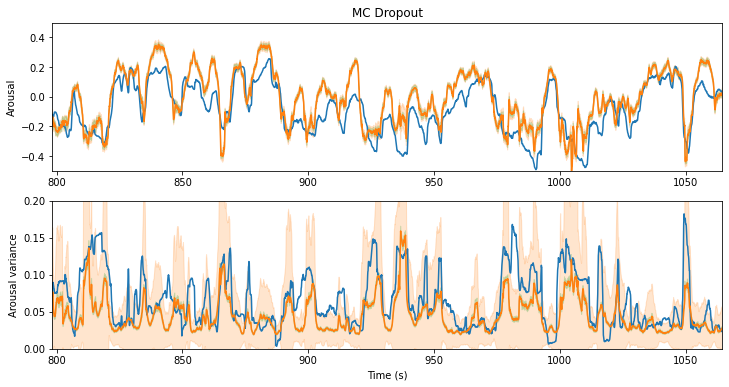

In [174]:
npresults = np.array(test_pred_dual)
time_step = 0.04*frame_step
num_steps = npresults.shape[1]
file_num = 3
time_start = file_num*time_step*num_steps/10
time_end = (file_num+1)*time_step*num_steps/10
time_stamps = np.arange(num_steps)*time_step

test = y_test[:,frame_length-1,0].flatten()
pred_mean = np.mean(npresults[:,:,frame_length-1,0],axis=0).flatten()
test_var = y_test_var[:,frame_length-1,0].flatten()
pred_amb = np.zeros((test.shape[0],))

mv_pred = np.zeros([num_models,npresults.shape[1],1,2])
dunc = np.zeros([npresults.shape[1],2,2])
dunc_lo = np.zeros([npresults.shape[1],])
for m in range(num_models):
    
#     nu = npresults[m,:,frame_length-1,1].flatten()
    alpha = npresults[m,:,frame_length-1,2].flatten()
    beta = npresults[m,:,frame_length-1,3].flatten()
    
    pred_amb_m = beta/(alpha-1)

    mv_pred[m,:,0,0] = npresults[m,:,frame_length-1,0]
    mv_pred[m,:,0,1] = pred_amb_m
    
    dunc[:,0,0] += npresults[m,:,frame_length-1,1]/num_models
    dunc[:,1,1] += (beta**2/alpha)/num_models
    
    dunc_lo += (beta/(alpha))/num_models

munc = np.zeros([npresults.shape[1],2,2])
mv_pred_ave = np.mean(mv_pred,axis=0)
for m in range(num_models):
    diff_m = mv_pred[m,:,:] - mv_pred_ave
    munc += np.matmul( diff_m.transpose(0,2,1),diff_m)
    
munc = munc/(num_models-1)

test_pred_var = mv_pred_ave[:,0,1]
munc_la = np.sqrt(munc[:,0,0])
dunc_la = np.sqrt(dunc[:,0,0])
tunc_la = np.sqrt(munc[:,0,0]+dunc[:,0,0])
munc_amb = np.sqrt(munc[:,1,1])
dunc_amb = np.sqrt(dunc[:,1,1])
tunc_amb = np.sqrt(munc[:,1,1]+dunc[:,1,1])
dunc_1 = np.sqrt(np.linalg.det(dunc))
munc_1 = np.sqrt(np.linalg.det(munc))

fig, axs = plt.subplots(2)
fig.set_size_inches(12,6)
axs[0].set_title('MC Dropout')

axs[0].set_xlim([time_start,time_end])
axs[0].set_ylim([-0.5,0.5])
axs[0].set_ylabel('Arousal')
axs[0].plot(time_stamps, test, label='Annotation mean')
axs[0].plot(time_stamps, test_pred, label='Predicted mean')
axs[0].fill_between(time_stamps, test_pred-tunc_la,test_pred+tunc_la,color='C1',alpha=0.2, label='Total uncertainty')
axs[0].fill_between(time_stamps, test_pred-munc_la,test_pred+munc_la,color='C2',alpha=0.2, label='Model uncertainty')
# axs[0].legend(loc='upper right')


axs[1].set_xlim([time_start,time_end])
axs[1].set_ylim([0,0.2])
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Arousal variance')
axs[1].plot(time_stamps, test_var, label='Annotation variance')
axs[1].plot(time_stamps, test_pred_var, label='Predicted ambiguity')
axs[1].fill_between(time_stamps, test_pred_var-tunc_amb,test_pred_var+tunc_amb,color='C1',alpha=0.2, label='Total uncertainty')
axs[1].fill_between(time_stamps, test_pred_var-munc_amb,test_pred_var+munc_amb,color='C2',alpha=0.2, label='Model uncertainty')
# axs[1].legend(loc='upper right')

print(my_ccc(test,test_pred))
print(my_ccc(test_var,test_pred_var))
print(my_ccc(np.sqrt(test_var),np.sqrt(test_pred_var)))
print(my_nll(y_test_multi, test_pred, np.sqrt(test_pred_var+dunc[:,0,0]+munc[:,0,0])))
# print(my_nll(y_test_multi, test_pred, np.sqrt(test_pred_var)))

In [62]:
np.sqrt(np.mean((test-test_pred)**2))

0.13143456072186532

In [144]:
np.sqrt(np.mean((test_var-test_pred_var)**2))

0.03507792984600905

In [146]:
def my_nll_loss(y_true, y_pred):
    
#     y_true = y_true[:,:,0]
    mean = y_pred[:,:,0]
    variance = y_pred[:,:,1]
    mean2 = y_pred[:,:,2]
    variance2 = y_pred[:,:,3]
    Vamb = mean2/6
    nll = 0
    
    y = tf.math.reduce_mean(y_true,axis=2)
    var = tf.math.reduce_variance(y_true,axis=2)
    
    nll += 0.5*(tf.math.log(variance+Vamb) + ((y - mean) ** 2)/(variance+Vamb) + 1.837877)
    nll += 0.5*(tf.math.log(variance2) + ((var - mean2) ** 2)/variance2 + 1.837877)

    return nll

rcoeff = 0#.001#.01
inputs = Input(shape=(frame_length,88))
x = Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=dropout_rate, kernel_regularizer=regularizers.l2(rcoeff)))(inputs, training=True)
# x = Dropout(dropout_rate)(x, training=True)
x = Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=dropout_rate, kernel_regularizer=regularizers.l2(rcoeff)))(x, training=True)
# x = Dropout(dropout_rate)(x, training=True)
mean = Dense(1, activation="tanh")(x)
var = Dense(1, activation="softplus")(x)
mean_var = Dense(1, activation="softplus")(x)
var_var = Dense(1, activation="softplus")(x)
outputs = Concatenate()([mean, var, mean_var, var_var])
# mean = Dense(1, activation="tanh")(x)
# variance = Dense(1, activation="softplus")(x)
# alpha = Dense(1, activation="softplus")(x)
# beta = Dense(1, activation="softplus")(x)
# outputs = Concatenate()([mean, variance, alpha+1, beta]) #4 parameters of NIG distribution

model_nll = keras.Model(inputs, outputs)
model_nll.summary()

#train model
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_nll.compile(optimizer=optimizer, loss=my_nll_loss)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto', min_delta=0.0001, restore_best_weights=True)
model_nll.fit(x_train,y_train_multi, batch_size=100, epochs=100, validation_split=0.1, shuffle=True, callbacks=[early_stopping])


Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 10, 88)]     0                                            
__________________________________________________________________________________________________
bidirectional_48 (Bidirectional (None, 10, 128)      78336       input_25[0][0]                   
__________________________________________________________________________________________________
bidirectional_49 (Bidirectional (None, 10, 128)      98816       bidirectional_48[0][0]           
__________________________________________________________________________________________________
dense_92 (Dense)                (None, 10, 1)        129         bidirectional_49[0][0]           
___________________________________________________________________________________________

In [147]:
test_pred_nll = mcdropout_predict(x_test, model_nll)
# test_pred_nll = test_pred_dual

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


(33264, 2, 2)
0.7673696292084794
0.41356769954487643
-0.7362405457933231
0.12524814335019163
0.036266360251584126


0.06999410371774863

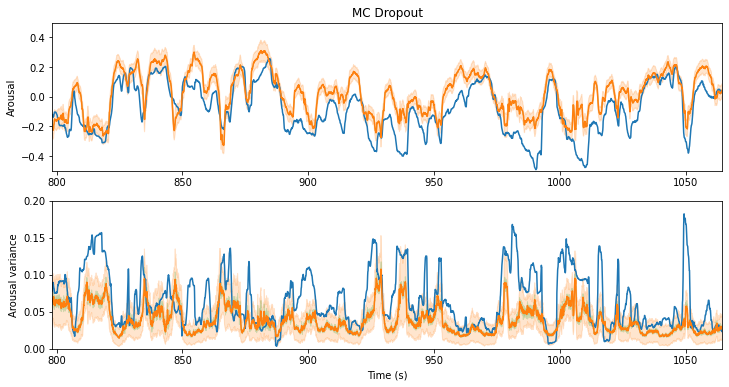

In [186]:
npresults = np.array(test_pred_nll)

time_step = 0.04*frame_step
num_steps = npresults.shape[1]
file_num = 3
time_start = file_num*time_step*num_steps/10
time_end = (file_num+1)*time_step*num_steps/10
time_stamps = np.arange(num_steps)*time_step


test = y_test[:,frame_length-1,0].flatten()
test_pred = np.mean(npresults[:,:,frame_length-1,0],axis=0).flatten()
# test_std = y_test_std[:,frame_length-1,0].flatten()
test_std = np.var(y_test_multi[:,frame_length-1,:],axis=1).flatten()
test_pred_std = np.zeros((test.shape[0],))

num_models = 5
mv_pred = np.zeros([num_models,npresults.shape[1],1,2])
dunc = np.zeros([npresults.shape[1],2,2])
for m in range(num_models):
#     test_pred_std += test_pred_nll[m,:,frame_length-1,1] + np.square(test_pred_nll[m,:,frame_length-1,0])
    
    amb_m = npresults[m,:,frame_length-1,2]
    var_mu_m = npresults[m,:,frame_length-1,1]
    var_amb_m = npresults[m,:,frame_length-1,3]
    general_var_m = var_mu_m*var_amb_m

    mv_pred[m,:,0,0] = mu
    mv_pred[m,:,0,1] = amb_m
#   Using multivariate covariance
    dunc[:,0,0] += var_mu_m/num_models
    dunc[:,1,1] += var_amb_m/num_models

munc = np.zeros([npresults.shape[1],2,2])
mv_pred_ave = np.mean(mv_pred,axis=0)
print(munc.shape)
for m in range(num_models):
    diff_m = mv_pred[m,:,:] - mv_pred_ave
    munc += np.matmul( diff_m.transpose(0,2,1),diff_m)
#     print(diff_i[0,:,:])
#     print(diff_i.transpose(0,2,1)[0,:,:])
#     print(munc[0,:,:])
    
munc = munc/(num_models-1)

test_pred_std = mv_pred_ave[:,0,1]

munc_la = np.sqrt(munc[:,0,0])
dunc_la = np.sqrt(dunc[:,0,0])
tunc_la = np.sqrt(munc[:,0,0]+dunc[:,0,0])
munc_amb = np.sqrt(munc[:,1,1])
dunc_amb = np.sqrt(dunc[:,1,1])
tunc_amb = np.sqrt(munc[:,1,1]+dunc[:,1,1])
# dunc_1 = np.sqrt(np.linalg.det(dunc))
# munc_1 = np.sqrt(np.linalg.det(munc))

fig, axs = plt.subplots(2)
fig.set_size_inches(12,6)

axs[0].set_title('MC Dropout')
axs[0].set_xlim([time_start,time_end])
# axs[0].set_xlim([0,66519])
axs[0].set_ylim([-0.5,0.5])
# axs[0].set_xlabel('Frame')
axs[0].set_ylabel('Arousal')
axs[0].plot(time_stamps, test, label='Mean annotation')
axs[0].plot(time_stamps, test_pred, label='Prediction')
# for i in range(num_models):
#     axs[0].plot(np.abs(mv_pred[i,:,0,0]-mv_pred_ave[:,0,0])+0.5)
#     axs[0].plot(np.abs(mv_pred[i,:,0,1]-mv_pred_ave[:,0,1])-0.5)
# axs[0].plot(test_pred_unc)
# axs[0].plot(np.sqrt(munc_mean)-1, label='predicted model uncertainty - 1')
# axs[0].plot(np.sqrt()-1, label='predicted data uncertainty - 1')
axs[0].fill_between(time_stamps, test_pred-tunc_la,test_pred+tunc_la,color='C1',alpha=0.2, label='Total uncertainty')
axs[0].fill_between(time_stamps, test_pred-munc_la,test_pred+munc_la,color='C2',alpha=0.2, label='Model uncertainty')
# axs[0].legend(loc='upper right')

axs[1].set_xlim([time_start,time_end])
# axs[1].set_xlim([0,66519])
axs[1].set_ylim([0,0.2])
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Arousal variance')
axs[1].plot(time_stamps, test_std, label='Inter-rater variance')
axs[1].plot(time_stamps, test_pred_std, label='Predicted ambiguity')
axs[1].fill_between(time_stamps, test_pred_std-tunc_amb,test_pred_std+tunc_amb,color='C1',alpha=0.2, label='Total uncertainty')
axs[1].fill_between(time_stamps, test_pred_std-munc_amb,test_pred_std+munc_amb,color='C2',alpha=0.2, label='Model uncertainty')
# axs[1].legend(loc='upper right')

print(my_ccc(test,test_pred))
print(my_ccc(np.sqrt(test_std),np.sqrt(test_pred_std)))
print(my_nll(y_test_multi, test_pred, np.sqrt(test_pred_std+dunc[:,0,0]+munc[:,0,0])))
print(np.sqrt(np.mean((test-test_pred)**2)))
print(np.sqrt(np.mean((test_std-test_pred_std)**2)))
np.sqrt(np.mean((np.sqrt(test_std)-np.sqrt(test_pred_std))**2))

C:\Users\Hazmeme\AppData\Local\Temp/ipykernel_10452/3139355536.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  conf.append(np.sqrt(np.mean(np.square(tunc_la[index]))))
C:\Users\Hazmeme\AppData\Local\Temp/ipykernel_10452/3139355536.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rmse.append(np.sqrt(np.mean(np.square(test[index]-test_pred[index]))))
d:\school\thesis\scrap\.env\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\school\thesis\scr

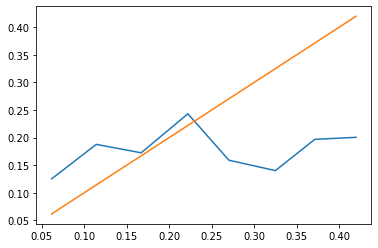

In [155]:
conf = []
rmse = []
for thresh in [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]:
    index = [(tunc_la<thresh) * (tunc_la>(thresh-0.05))]
    conf.append(np.sqrt(np.mean(np.square(tunc_la[index]))))
    rmse.append(np.sqrt(np.mean(np.square(test[index]-test_pred[index]))))

plt.plot(conf,rmse)
plt.plot(conf,conf)

C:\Users\Hazmeme\AppData\Local\Temp/ipykernel_10452/1657158811.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  conf.append(np.sqrt(np.mean(np.square(tunc_amb[index]))))
C:\Users\Hazmeme\AppData\Local\Temp/ipykernel_10452/1657158811.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rmse.append(np.sqrt(np.mean(np.square(test_pred_std[index]-test_var[index]))))


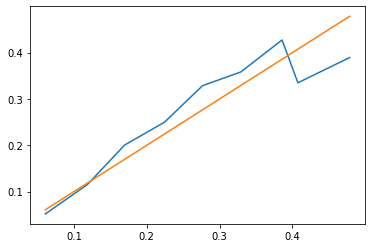

In [156]:
conf = []
rmse = []
for thresh in [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]:
    index = [(tunc_amb<thresh) * (tunc_amb>(thresh-0.05))]
    conf.append(np.sqrt(np.mean(np.square(tunc_amb[index]))))
    rmse.append(np.sqrt(np.mean(np.square(test_pred_std[index]-test_var[index]))))

plt.plot(conf,rmse)
plt.plot(conf,conf)

C:\Users\Hazmeme\AppData\Local\Temp/ipykernel_10452/4292488934.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  conf.append(np.sqrt(np.mean(np.square(tunc_la[index]))))
C:\Users\Hazmeme\AppData\Local\Temp/ipykernel_10452/4292488934.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rmse.append(np.sqrt(np.mean(np.square(test[index]-test_pred[index]))))
C:\Users\Hazmeme\AppData\Local\Temp/ipykernel_10452/4292488934.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead

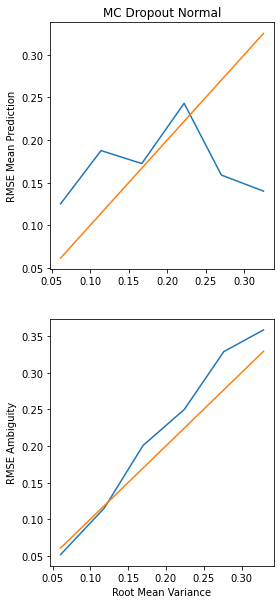

In [167]:
conf = []
rmse = []
for thresh in [0.1,0.15,0.2,0.25,0.3,0.35]:
    index = [(tunc_la<thresh) * (tunc_la>(thresh-0.05))]
    conf.append(np.sqrt(np.mean(np.square(tunc_la[index]))))
    rmse.append(np.sqrt(np.mean(np.square(test[index]-test_pred[index]))))

fig, axs = plt.subplots(2)
fig.set_size_inches(4,10)

axs[0].set_title('MC Dropout Normal')
axs[0].set_ylabel('RMSE Mean Prediction')
axs[0].plot(conf,rmse)
axs[0].plot(conf,conf)

conf = []
rmse = []
for thresh in [0.1,0.15,0.2,0.25,0.3,0.35]:
    index = [(tunc_amb<thresh) * (tunc_amb>(thresh-0.05))]
    conf.append(np.sqrt(np.mean(np.square(tunc_amb[index]))))
    rmse.append(np.sqrt(np.mean(np.square(test_pred_std[index]-test_var[index]))))

axs[1].set_xlabel('Root Mean Variance')
axs[1].set_ylabel('RMSE Ambiguity')
axs[1].plot(conf,rmse)
axs[1].plot(conf,conf)


0.09470565481550633

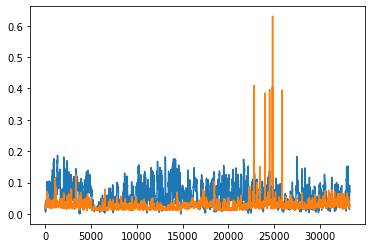

In [187]:
plt.plot(test_var)
plt.plot(tunc_amb)
# plt.xlim([10000,15000])
my_ccc(tunc_amb, test_var)